# Data Cleaning

## Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from html import unescape
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# this setting widens how many characters pandas will display in a column:
pd.options.display.max_colwidth = 400

## Read Files
Read in any files created by data collection

In [2]:
tickets = pd.read_csv('../data/sat_tix.csv')
metrics = pd.read_csv('../data/tix_mets.csv')
comments = pd.read_csv('../data/tix_comments.csv')

In [3]:
tickets.shape, metrics.shape, comments.shape

((13323, 10), (13323, 22), (85692, 11))

Tickets and metrics have the count of rows, so it's possible we can merge these together

## Ticket Data Cleaning

In [ ]:
tickets.head(3)

In [5]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13323 entries, 0 to 13322
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           13323 non-null  int64 
 1   type         8384 non-null   object
 2   subject      13323 non-null  object
 3   description  13323 non-null  object
 4   status       13323 non-null  object
 5   recipient    4987 non-null   object
 6   group_id     13323 non-null  int64 
 7   channel      13323 non-null  object
 8   sat_score    13323 non-null  object
 9   sat_comment  4288 non-null   object
dtypes: int64(2), object(8)
memory usage: 1.0+ MB


There are a fair number of nulls in the `type` and `recipient` and `sat_comment`.  `sat_comment` is optional when leaving satisfaction feedback, so that makes sense, but will investigate the other two columns' nulls.

In [6]:
tickets['type'].nunique()

4

In [7]:
tickets['type'].unique()

array([nan, 'question', 'problem', 'incident', 'task'], dtype=object)

This type is a sub-categorization of ticket and not widely used throughout the organization that this data was collected from.  It is not relevant to our analysis, so this column should be dropped.

In [8]:
tickets['status'].unique()

array(['closed'], dtype=object)

All the statuses are 'closed' which is to be expected as that was part of the search criteria from the data collection.

This column should also be dropped.

In [ ]:
tickets['recipient'].unique()

This looks like it could be useful information, but there are majority of the entries are missing.  Let's check out the Group ID and see if that might relate.

In [ ]:
tickets.groupby(['group_id', 'recipient']).all()

There doesn't appear to be a 1:1 relationship between `group_id` and `recipient`, which I thought might be the case.  I don't believe this information is important for the project at hand, so I will drop for now.  If it is deemed that this information is needed we'll have to collect some additional via API in order for this to be useful.

In [11]:
tickets.drop(columns=['recipient', 
                      'group_id', 
                      'type', 
                      'status'
                     ], inplace=True)

In [12]:
tickets.isna().sum()

id                0
subject           0
description       0
channel           0
sat_score         0
sat_comment    9035
dtype: int64

The only remaining null values are ones that are expected.

In [13]:
tickets['sat_score'].value_counts(normalize=True)

good    0.854612
bad     0.145388
Name: sat_score, dtype: float64

Imbalanced class could be a challenge for modeling.  Will keep this in mind going forward.

## Ticket Metrics Data Cleaning

|Name|	Type|	Read-only|	Mandatory	|Description|
|:--|:--|:--|:--|:--|
|agent_wait_time_in_minutes|	object|	true|	false|	Number of minutes the agent spent waiting during calendar and business hours|
|assigned_at|	string|	true|	false|	When the ticket was assigned|
|assignee_stations|	integer|	true|	false|	Number of assignees the ticket had|
|assignee_updated_at|	string|	true|	false|	When the assignee last updated the ticket|
|created_at|	string|	true|	false|	When the record was created|
|custom_status_updated_at|	string|	true|	false|	The date and time the ticket's custom status was last updated|
|first_resolution_time_in_minutes|	object|	true|	false|	Number of minutes to the first resolution time during calendar and business hours|
|full_resolution_time_in_minutes|	object|	true|	false|	Number of minutes to the full resolution during calendar and business hours|
|group_stations|	integer|	true|	false|	Number of groups the ticket passed through|
|id|	integer|	true|	false|	Automatically assigned when the client is created|
|initially_assigned_at|	string|	true|	false|	When the ticket was initially assigned|
|latest_comment_added_at|	string|	true|	false|	When the latest comment was added|
|on_hold_time_in_minutes|	object|	true|	false|	Number of minutes on hold|
|reopens|	integer|	true|	false|	Total number of times the ticket was reopened|
|replies|	integer|	true|	false|	The number of public replies added to a ticket by an agent|
|reply_time_in_minutes|	object|	true|	false|	Number of minutes to the first reply during calendar and business hours|
|reply_time_in_seconds|	object|	true|	false|	Number of seconds to the first reply during calendar hours, only available for Messaging tickets|
|requester_updated_at|	string|	true|	false|	When the requester last updated the ticket|
|requester_wait_time_in_minutes|	object|	true|	false|	Number of minutes the requester spent waiting during calendar and business hours|
|solved_at|	string|	true|	false|	When the ticket was solved|
|status_updated_at|	string|	true|	false|	When the status of the ticket was last updated|
|ticket_id|	integer|	true|	false|	Id of the associated ticket|
|updated_at|	string|	true|	false|	When the record was last updated|
|url|	string|	true|	false|	The API url of the ticket metric|

[source](https://developer.zendesk.com/api-reference/ticketing/tickets/ticket_metrics/#json-format)

In [ ]:
metrics.head(3)

In [15]:
metrics.columns

Index(['url', 'id', 'ticket_id', 'created_at', 'updated_at', 'group_stations',
       'assignee_stations', 'reopens', 'replies', 'assignee_updated_at',
       'requester_updated_at', 'status_updated_at', 'initially_assigned_at',
       'assigned_at', 'solved_at', 'latest_comment_added_at',
       'reply_time_in_minutes', 'first_resolution_time_in_minutes',
       'full_resolution_time_in_minutes', 'agent_wait_time_in_minutes',
       'requester_wait_time_in_minutes', 'on_hold_time_in_minutes'],
      dtype='object')

Shortening some of the column names

In [16]:
metrics.isna().sum()[metrics.isna().sum() > 0]

assignee_updated_at      161
initially_assigned_at     28
assigned_at               28
reply_time_in_minutes    412
dtype: int64

More information about these fields [(source)](https://developer.zendesk.com/api-reference/ticketing/tickets/ticket_metrics/#json-format):
|Field|Definition|
|:--|:--|
|assignee_updated_at|When the assignee last updated the ticket|
|initially_assigned_at|When the ticket was initially assigned|
|assigned_at|When the ticket was assigned|
|reply_time_in_minutes|Number of minutes to the first reply during calendar and business hours|

Checking to see if the `assigned_at` missing values are all the same rows.

In [17]:
len(metrics
 [
     (metrics['initially_assigned_at'].isna()) 
     & (metrics['assigned_at'].isna())
 ]
)

28

It looks like the 28 rows with missing values are the same.  Since I'm familiar with the ticketing workflows, I do know that not all tickets get assigned.  Since this isn't a large amount of tickets, I'll substitute in the `latest_comment_added_at` as the normal culprit of not being assigned is replying to the ticket and/or attempting to solve it without the official assign step.

In [18]:
(metrics.loc[
    metrics[
     (metrics['initially_assigned_at'].isna()) 
     & (metrics['assigned_at'].isna())
    ].index, ['initially_assigned_at',
              'assigned_at', 'latest_comment_added_at']]).head()

,initially_assigned_at,assigned_at,latest_comment_added_at
212,NaN,NaN,2023-01-03T17:28:27Z
989,NaN,NaN,2022-11-02T16:52:27Z
1255,NaN,NaN,2022-11-08T22:21:03Z
1730,NaN,NaN,2022-07-29T21:47:46Z
2157,NaN,NaN,2022-05-20T20:31:18Z


In [19]:
for _ in ['initially_assigned_at',
          'assignee_updated_at',
          'assigned_at']:
    metrics[_].fillna(metrics['latest_comment_added_at'], inplace=True)

In [20]:
metrics.isna().sum()[metrics.isna().sum() > 0]

reply_time_in_minutes    412
dtype: int64

Examine the records with these null values

In [ ]:
(
    metrics
    [metrics['reply_time_in_minutes']
     .isna()]
    .sort_values(by='first_resolution_time_in_minutes', ascending=False)
    .head()
)

In [22]:
(
    metrics[['reply_time_in_minutes', 
         'first_resolution_time_in_minutes',
         'full_resolution_time_in_minutes',
         'agent_wait_time_in_minutes',
         'requester_wait_time_in_minutes']]
    .sort_values(
        by='first_resolution_time_in_minutes', 
        ascending=False)
    .head()
)

,reply_time_in_minutes,first_resolution_time_in_minutes,full_resolution_time_in_minutes,agent_wait_time_in_minutes,requester_wait_time_in_minutes
13296,2259.0,2253693,2253693,6677,2247016
12068,35.0,1968719,2286965,39,2286886
11918,70.0,1907196,1907196,2009,1905185
11454,144.0,1889228,1889228,960,1888268
11601,1142.0,1856054,1856054,0,1856054


In [23]:
metrics['reply_time_in_minutes'].describe()

count     12911.000000
mean        937.439470
std        6055.497408
min           0.000000
25%          66.000000
50%         203.000000
75%         532.000000
max      286188.000000
Name: reply_time_in_minutes, dtype: float64

After looking through some of the values, I belive that filling these with their first resolution time won't materially change the complexion of the data

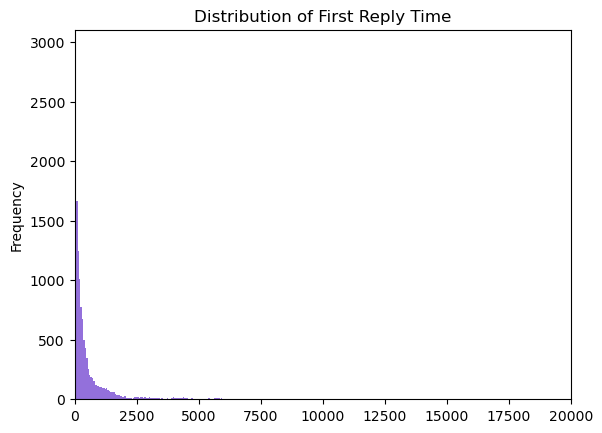

In [24]:
(
    metrics['reply_time_in_minutes']
    .plot(kind='hist',
          bins=5000,
          color='mediumpurple',
          title='Distribution of First Reply Time')
)
plt.xlim(0,20000);

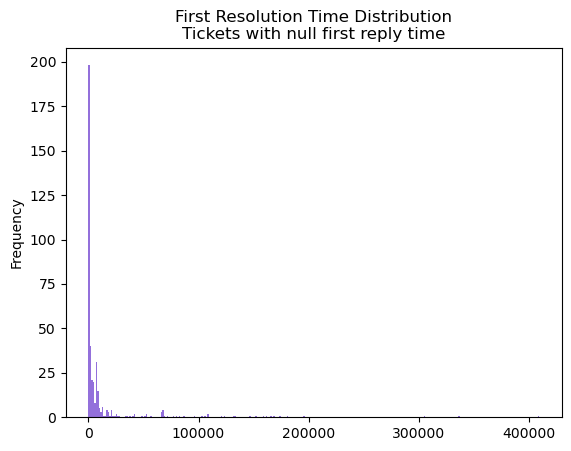

In [25]:
(
    metrics
    [metrics['reply_time_in_minutes'].isna()]
    ['first_resolution_time_in_minutes']
    .plot(
        bins=300,
        kind='hist',
        color='mediumpurple',
        title='First Resolution Time Distribution\n\
Tickets with null first reply time')
);

It's difficult to tell, but I don't think the proposed solution to filling values will alter this distribution in a meaningful way.

In [26]:
metrics.isna().sum()[metrics.isna().sum() > 0]

reply_time_in_minutes    412
dtype: int64

In [27]:
(
    metrics['reply_time_in_minutes']
    .fillna(
        metrics['first_resolution_time_in_minutes'], 
        inplace=True
    )
)

In [28]:
metrics.isna().sum()[metrics.isna().sum() > 0]

Series([], dtype: int64)

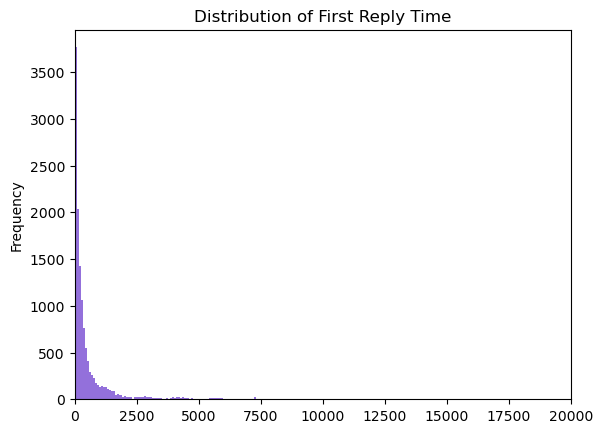

In [29]:
(
    metrics['reply_time_in_minutes']
    .plot(kind='hist',
          bins=5000,
          color='mediumpurple',
          title='Distribution of First Reply Time'
         )
)
plt.xlim(0,20000);

The shape of this distribution appears to be similar as before filling the null values.

### Shorten Column Names

To make this a bit easier to work with, the column names will be abbreviated.

In [30]:
metrics.columns

Index(['url', 'id', 'ticket_id', 'created_at', 'updated_at', 'group_stations',
       'assignee_stations', 'reopens', 'replies', 'assignee_updated_at',
       'requester_updated_at', 'status_updated_at', 'initially_assigned_at',
       'assigned_at', 'solved_at', 'latest_comment_added_at',
       'reply_time_in_minutes', 'first_resolution_time_in_minutes',
       'full_resolution_time_in_minutes', 'agent_wait_time_in_minutes',
       'requester_wait_time_in_minutes', 'on_hold_time_in_minutes'],
      dtype='object')

In [31]:
sub_dict = {
    'assignee': 'asign',
    'updated': 'updtd',
    'group': 'grp',
    'in_minutes': 'mins',
    'agent': 'agt',
    'resolution': 'reso',
    'requester': 'reqstr',
    'time_': '',
    '_at' : ''
    }

for key, value in sub_dict.items():
    metrics.columns = [col.replace(key, value) for col in metrics.columns]

In [32]:
metrics.columns

Index(['url', 'id', 'ticket_id', 'created', 'updtd', 'grp_stations',
       'asign_stations', 'reopens', 'replies', 'asign_updtd', 'reqstr_updtd',
       'status_updtd', 'initially_assigned', 'assigned', 'solved',
       'latest_comment_added', 'reply_mins', 'first_reso_mins',
       'full_reso_mins', 'agt_wait_mins', 'reqstr_wait_mins', 'on_hold_mins'],
      dtype='object')

In [ ]:
metrics.head(3)

The `id` column is an id for the metrics record, which we won't need to reference.  We'll merge and cross-reference based on the `ticket_id` column.  We also don't need the `url` column as that is just a direct pointer to the metrics record.

In [34]:
metrics.drop(columns=['url', 'id'], inplace=True)

## Merge Ticket and Metrics Data

Since the data between tickets and metrics is 1-to-1, we'll merge this into a single dataframe.  After this is merged, the columns will be checked again to see if there are any additional that should be dropped at this point.

In [35]:
tickets.shape, metrics.shape

((13323, 6), (13323, 20))

In [36]:
ticket_data = pd.merge(tickets, 
                       metrics, 
                       left_on='id', 
                       right_on='ticket_id', 
                        how='left')

In [37]:
ticket_data.shape

(13323, 26)

In [ ]:
ticket_data.head(3)

In [39]:
ticket_data.dtypes

id                        int64
subject                  object
description              object
channel                  object
sat_score                object
sat_comment              object
ticket_id                 int64
created                  object
updtd                    object
grp_stations              int64
asign_stations            int64
reopens                   int64
replies                   int64
asign_updtd              object
reqstr_updtd             object
status_updtd             object
initially_assigned       object
assigned                 object
solved                   object
latest_comment_added     object
reply_mins              float64
first_reso_mins           int64
full_reso_mins            int64
agt_wait_mins             int64
reqstr_wait_mins          int64
on_hold_mins              int64
dtype: object

### Convert to datetime

Convert all the timestamp fields to datetime type

In [40]:
ticket_data.columns

Index(['id', 'subject', 'description', 'channel', 'sat_score', 'sat_comment',
       'ticket_id', 'created', 'updtd', 'grp_stations', 'asign_stations',
       'reopens', 'replies', 'asign_updtd', 'reqstr_updtd', 'status_updtd',
       'initially_assigned', 'assigned', 'solved', 'latest_comment_added',
       'reply_mins', 'first_reso_mins', 'full_reso_mins', 'agt_wait_mins',
       'reqstr_wait_mins', 'on_hold_mins'],
      dtype='object')

In [41]:
dt_fields = [
    'created', 
    'updtd',
    'asign_updtd', 
    'reqstr_updtd',
    'status_updtd', 
    'initially_assigned', 
    'assigned', 
    'solved',
    'latest_comment_added'
]

for dt in dt_fields:
    ticket_data[dt] = pd.to_datetime(ticket_data[dt])

In [42]:
ticket_data.dtypes

id                                    int64
subject                              object
description                          object
channel                              object
sat_score                            object
sat_comment                          object
ticket_id                             int64
created                 datetime64[ns, UTC]
updtd                   datetime64[ns, UTC]
grp_stations                          int64
asign_stations                        int64
reopens                               int64
replies                               int64
asign_updtd             datetime64[ns, UTC]
reqstr_updtd            datetime64[ns, UTC]
status_updtd            datetime64[ns, UTC]
initially_assigned      datetime64[ns, UTC]
assigned                datetime64[ns, UTC]
solved                  datetime64[ns, UTC]
latest_comment_added    datetime64[ns, UTC]
reply_mins                          float64
first_reso_mins                       int64
full_reso_mins                  

### Clean Description Field

Before moving to EDA, I'll clean the description field with the following:
* Remove Newline Characters
* Remove URLs
* Remove Emails
* Remove Extra Spaces

#### Remove Newline Characters

In [43]:
ticket_data['description'] = \
ticket_data['description'].str.replace('\n', ' ', regex=True)

#### URLs
In order to be able to remove URLs effectively, I think they should be removed before additional processing.   

In [44]:
# found URL regex at : https://urlregex.com
url_p = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# check to see if any matches in the text
ticket_data['description'].str.contains(url_p).sum()

3242

Since that pattern seemed to identify some URLs in the text, I will remove them

In [45]:
ticket_data['description'] = \
ticket_data['description'].str.replace(url_p, '', regex=True)

In [46]:
# check that worked
ticket_data['description'].str.contains(url_p).sum()

0

#### Emails
Email addresses will also be removed for privacy concerns.

In [47]:
# found email regex at : https://stackoverflow.com/questions/44027943/python-regex-to-remove-emails-from-string
email_p = '\S*@\S*\s?'

# check to see if any matches in the text
ticket_data['description'].str.contains(email_p).sum()

3479

Since that pattern seemed to identify many email address in the text, I will remove them.

In [48]:
ticket_data['description'] = \
ticket_data['description'].str.replace(email_p, '', regex=True)

In [49]:
# check that worked
ticket_data['description'].str.contains(email_p).sum()

0

#### Extra Spaces
Remove all extra spaces from the text before combining posts text data.

In [50]:
# check for extra spaces
ticket_data['description'].str.contains('\s\s+').sum()

11385

In [51]:
ticket_data['description'] = \
ticket_data['description'].str.replace('\s\s+', ' ', regex=True)

In [52]:
# check for extra spaces
ticket_data['description'].str.contains('\s\s+').sum()

0

#### Encoded Characters

Again, like URLs, we will want to process any encoded characters, specifically, I spotted some of the HTML encoded characters, so we'll tackle those first and can come back and change this later if we need to.

In [53]:
# get rid of html escape characters
ticket_data['description'] = ticket_data['description'].apply(unescape)

In [ ]:
ticket_data.head(3)

## Comments Cleaning

This section will focus on cleaning the comment data.  The main purpose of the comment data will be to use some NLP sentiment analysis so that, eventually, the comments sentiment can be added to the `ticket_data` as another feature before modeling.  So this cleaning will be NLP focused, but also, since sentiment and possibly context is important, there might be a lighter touch with removing certain elements.

This data is a different shape as one ticket will have multiple comments, as a comment is defined by a post/reply by a customer, or by a support agent. Each comment has its own entry in this dataframe.

|Name|	Type|	Read-only|	Mandatory|	Description|
|:--|:--|:--|:--|:--|
|audit_id|	integer|	true|	false|	The id of the ticket audit record. See Show Audit|
|author_id|	integer|	false|	false|	The id of the comment author. See Author id|
|body|	string|	false|	false|	The comment string. See Bodies|
|created_at|	string|	true|	false|	The time the comment was created|
|html_body|	string|	false|	false|	The comment formatted as HTML. See Bodies|
|id|	integer|	true|	false|	Automatically assigned when the comment is created|
|plain_body|	string|	true|	false|	The comment as plain text. See Bodies|
|public|	boolean|	false|	false|	true if a public comment; false if an internal note. The initial value set on ticket creation persists for any additional comment unless you change it|
|type|	string|	true|	false|	Comment or VoiceComment.|
|channel|string|n/a|n/a| Extracted from a nested JSON object during data collection.  Indicates channel ticket was created with.|
|ticket_id|integer|n/a|n/a| Ticket ID for comment - extracted during data collection.|


[source](https://developer.zendesk.com/api-reference/ticketing/tickets/ticket_comments/#json-format)

In [55]:
comments.columns

Index(['id', 'type', 'author_id', 'body', 'html_body', 'plain_body', 'public',
       'audit_id', 'created_at', 'channel', 'ticket_id'],
      dtype='object')

In [56]:
comments.isna().sum()[comments.isna().sum() > 0]

plain_body    1
dtype: int64

In [57]:
comments = comments.dropna()

In [58]:
comments.isna().sum()[comments.isna().sum() > 0]

Series([], dtype: int64)

### Drop Columns
From the description and the intended use of this data, means we can drop the following columns:
* `audit_id`
* `id`
* `type` (voice is not in use, so all will be comments)
* `html_body`

Although the remaining columns may not all be used for modeling, they may be interesting for EDA, so will leave them in for now.

In [59]:
comments.drop(columns=['audit_id',
                       'id',
                       'type',
                       'html_body'],
              inplace=True)

### Body Columns

In trying to choose between the `body` and `plain_body`, there is some information in the [API documentation](https://developer.zendesk.com/api-reference/ticketing/tickets/ticket_comments/#bodies):

Three types of bodies are supported: plain_body, body, and html_body. html_body is the least sanitized option; plain_body is the most sanitized. Text input in body defaults to plain_body if there's an error in sanitizing.
* Markdown formatting is supported in body but not in html_body. 
* You can include ticket placeholders in the body or html_body. 

When the request is processed, the placeholder is replaced by a value if one is available. If the placeholder is not supported (example, {{fake}}), the placeholder is stripped out.

**Body size limits**
* Ticket comment bodies are limited to 64kB. Any characters exceeding this limit are truncated. No error is reported.

Since HTML and special formatting will not help, the `body` column will be dropped in favor of the `plain_body` columns

In [60]:
comments.drop(columns=['body'], inplace=True)

In [ ]:
comments.head(3)

### Body Cleaning

From what I've seen in the body so far, There are some elements that should be cleaned up:

* `\n` newline characters
* URLs
* unescape encoded characters
* extra spaces

After that, I'll sample some of the body texts and see what else might need to be considered for this cleaning.

VADER sentiment analysis will likely be used, and in reading the documentation further, there are provisions for case sensitivity, punctuation including emojis, and more, so I will NOT be normalizing case or removing punctuation.

After cleaning, during EDA, there may be additional items identified that will be added to this list, but this should be a good starting point.

> NOTE Some sampling was used throughout the steps below to check text to identify any concerns and see how various operations worked. That code is commented out to make the notebook more digestible.

#### Remove Newline Characters

In [62]:
comments['plain_body'] = comments['plain_body'
                                 ].str.replace('\n', ' ', regex=True)

#### Unicode Characters

After going through all the steps below, it was noted in a later step in EDA, that some there was a prevalence of `\xa0` in the text, which appear to be unicode break character.  So will try and deal with those at this point and then run through the remainder of the cleaning steps.

In [63]:
comments['plain_body'] = comments['plain_body'
                                 ].str.replace('\\xa0', ' ', regex=True)

#### URLs
In order to be able to remove URLs effectively, I think they should be removed before additional processing.   

In [64]:
# found URL regex at : https://urlregex.com
url_p = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

# check to see if any matches in the text
comments['plain_body'].str.contains(url_p).sum()

26460

Since that pattern seemed to identify some URLs in the text, I will remove them

In [65]:
comments['plain_body'] = \
comments['plain_body'].str.replace(url_p, '', regex=True)

In [66]:
# check that worked
comments['plain_body'].str.contains(url_p).sum()

0

#### Emails
Email addresses will also be removed for privacy concerns.

In [67]:
# found email regex at : https://stackoverflow.com/questions/44027943/python-regex-to-remove-emails-from-string
email_p = '\S*@\S*\s?'

# check to see if any matches in the text
comments['plain_body'].str.contains(email_p).sum()

28932

Since that pattern seemed to identify many email address in the text, I will remove them.

In [68]:
comments['plain_body'] = \
comments['plain_body'].str.replace(email_p, '', regex=True)

In [69]:
# check that worked
comments['plain_body'].str.contains(email_p).sum()

0

#### Extra Spaces
Remove all extra spaces from the text before combining posts text data.

In [70]:
# check for extra spaces
comments['plain_body'].str.contains('\s\s+').sum()

74778

In [71]:
comments['plain_body'] = comments['plain_body'].str.replace('\s\s+', ' ', regex=True)

In [72]:
# check for extra spaces
comments['plain_body'].str.contains('\s\s+').sum()

0

In [73]:
# comments[['plain_body']].sample(15)

#### Encoded Characters

Again, like URLs, we will want to process any encoded characters, specifically, I spotted some of the HTML encoded characters, so we'll tackle those first and can come back and change this later if we need to.

In [74]:
# get rid of html escape characters
comments['plain_body'] = comments['plain_body'].apply(unescape)

In [ ]:
comments[['plain_body']].sample(5)

Sampling Observations

When I went through and ran the sample cell multiple times, I just wanted to note some of the things that I observed that may be worth cleaning:
* phone numbers (US and international)
* websites without the protocol
* mailing/street addresses (US and international)
* names
* product and company specific terminology

Given some of the notes on the VADER sentiment analysis, I think I'm going to leave this as-is for now.  I may want to revisit this if the sentiment analysis isn't yielding good results, or some other issues arise.

### Sentiment Analysis

Here the sentiment score for each comment will be determined and then that information will be added to the `ticket_data` as another feature.

In [76]:
# instantiate SentimentIntensity Analyzer
sia = SentimentIntensityAnalyzer()

In [77]:
comments['sent_score'] = (
    comments['plain_body']
    .apply(lambda x: sia.polarity_scores(x).get('compound'))
)

In [ ]:
comments.head(3)

In [79]:
comments['sent_score'].describe()

count    85691.000000
mean         0.461137
std          0.451708
min         -1.000000
25%          0.077200
50%          0.600700
75%          0.840500
max          0.999900
Name: sent_score, dtype: float64

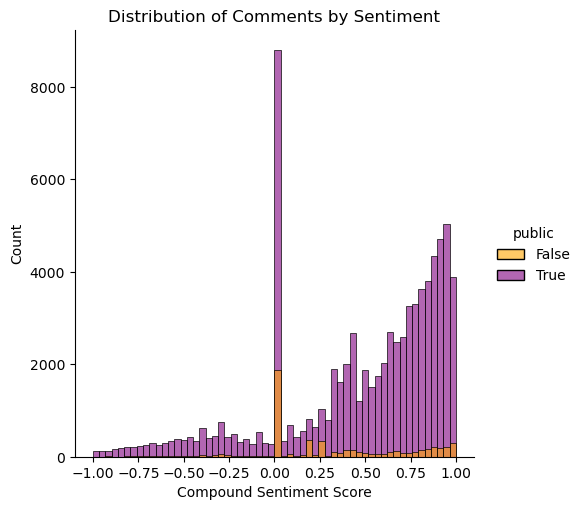

In [80]:
sns.displot(data=comments,
            x='sent_score',
            palette=['orange','purple'],
            alpha=0.6,
            hue='public').set(title='Distribution of Comments by Sentiment',
                              xlabel='Compound Sentiment Score');

Trying to check how much the public vs. private sentiment may differ.  Comments that are not public are entered by employees.  Since those private comments do not make it to the customer, it is unlikely that they would have a big impact, especially since it looks like the highest concentration of scores for private comments are neutral.

Since we haven't done EDA yet, I'm going to opt to create features for:
* public sentiment
* private sentiment
* combined sentiment

These will be investigated further in EDA and determined if they might be valuable to include in modeling.

In [81]:
comments['public'].value_counts(normalize=True)

True     0.932117
False    0.067883
Name: public, dtype: float64

After seeing how the distribution changed after combining the scores compared to how when they were all summarized by ticket, and seeing how few of the comments are private (6.8%), it now seems that leaving the score on the ticket as single value is the approach I want to take, so I'll create the scores data based off of averaging all the sentiment scores from all the comments on a ticket in order before merging this information back to the `ticket_data`.

In [82]:
# group by ticket in order to roll up the mean sentiment scores by comment type
# unstack to get private and public separate
scores = pd.DataFrame(
    comments.groupby(['ticket_id'])
    .agg({
        'sent_score': 'mean',
        'public': 'count'
    })
    .rename(columns={'public': 'num_comms'})
)

In [83]:
scores.head()

,sent_score,num_comms
ticket_id,,
43363,0.121767,6
43742,0.510884,25
43907,0.171736,25
46481,0.433131,13
47041,0.590213,8


## Merge and Export

Merge the sentiment scores for each ticket with the `ticket_data` before exporting.  I export the ticket_data which is the main set of data for this project, but also the comments data so EDA can be performed on both.

In [84]:
ticket_data = ticket_data.merge(scores, 
                                how='left',
                                left_on='id',
                                right_on='ticket_id')

In [ ]:
ticket_data.head(3)

In [86]:
ticket_data.isna().sum()[ticket_data.isna().sum() > 0]

sat_comment    9035
dtype: int64

In [87]:
# export as pickle to preserve datetime types, etc.
ticket_data.to_pickle('../data/ticket_data_clean.pkl')
comments.to_pickle('../data/comments_clean.pkl')